In [102]:
import pickle
import numpy as np
from sklearn.preprocessing import RobustScaler,MinMaxScaler
X_ppg,X_qual,X_acc,y_rr, y_respiration,y_inspiration,y_expiration,groups,X_respiration,y_activity,y_label = pickle.load(open('../../affect-recognition/data/tabular_data_8.p','rb'))

In [103]:
from sklearn.preprocessing import OneHotEncoder
index = np.where((y_activity!=0)&(y_activity!=3)&(y_activity!=6)&(y_activity!=8)&(y_activity!=2))[0]
X_acc = X_acc[index]
y_activity = y_activity[index]
groups = groups[index]
y_activity = OneHotEncoder().fit_transform(y_activity.reshape(-1,1)).todense()


/home/azim/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [104]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU,Conv1D,MaxPool1D,Dropout,BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tf
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=len(np.unique(groups)))
train,test = list(gkf.split(X_acc,groups=groups))[1]
X_acc_train,X_acc_test = X_acc[train],X_acc[test]
y_activity_train,y_activity_test = y_activity[train],y_activity[test]
y_activity_train.shape

(18156, 4)

In [130]:
def get_base_GRU(timesteps_ppg=256,input_dim_ppg=3,first_dim=60,
                 optimizer='adam',loss='binary_crossentropy',output_dim=9,
                 metrics = ['accuracy']):
    inputs = Input(shape=(timesteps_ppg, input_dim_ppg))
    encoded = Bidirectional(GRU(first_dim,return_sequences=True,activation='tanh',go_backwards=True))(inputs)
    dense_layer = TimeDistributed(Dense(1,activation='tanh'))(encoded)
    flattened = Flatten()(dense_layer)
    output = Dense(30,activation='relu')(flattened)
    output = Dense(output_dim,activation='sigmoid')(output)
    sequence_autoencoder = Model(inputs=[inputs], outputs=[output])
    sequence_autoencoder.compile(optimizer=optimizer,loss=loss,metrics=[metrics])
    return sequence_autoencoder

# fe = Conv1D(100,4, padding='same',activation='tanh')(merge)
#     fe = LeakyReLU(alpha=0.2)(fe)
#     fe = MaxPool1D(2)(fe)
#     fe = BatchNormalization()(fe)
# #     fe = Dropout(0.2)(fe)

def get_base_CNN(timesteps_ppg=256,input_dim_ppg=3,first_dim=60,
                 optimizer='adam',loss='kullback_leibler_divergence',output_dim=4,
                 metrics = ['accuracy']):
    inputs = Input(shape=(timesteps_ppg, input_dim_ppg))
    fe = Conv1D(100,4, padding='same',activation='tanh')(inputs)
#     fe = LeakyReLU(alpha=0.2)(fe)
    fe = MaxPool1D(2)(fe)
    fe = BatchNormalization()(fe)
    fe = Dropout(.2)(fe)
    fe = Conv1D(100,4, padding='same',activation='tanh')(fe)
#     fe = LeakyReLU(alpha=0.2)(fe)
    fe = MaxPool1D(4)(fe)
    fe = BatchNormalization()(fe)
    fe = Dropout(.2)(fe)
    fe = Conv1D(50,4, padding='same',activation='tanh')(fe)
#     fe = LeakyReLU(alpha=0.2)(fe)
    fe = MaxPool1D(8)(fe)
    fe = BatchNormalization()(fe)
    fe = Dropout(.2)(fe)
    
    flattened = Flatten()(fe)
    output = Dense(30,activation='relu')(flattened)
    output = Dense(output_dim,activation='sigmoid')(output)
#     output = Dense(output_dim,activation='softmax')(output)
    sequence_autoencoder = Model(inputs=[inputs], outputs=[output])
    sequence_autoencoder.compile(optimizer=optimizer,loss=loss,metrics=[metrics])
    return sequence_autoencoder

def get_base_GRU(timesteps_ppg=256,input_dim_ppg=3,first_dim=60,
                 optimizer='adam',loss='binary_crossentropy',output_dim=9,
                 metrics = ['accuracy']):
    inputs = Input(shape=(timesteps_ppg, input_dim_ppg))
    encoded = Bidirectional(GRU(first_dim,return_sequences=True,activation='tanh',go_backwards=True))(inputs)
    dense_layer = TimeDistributed(Dense(1,activation='relu'))(encoded)
    flattened = Flatten()(dense_layer)
    output = Dense(30,activation='relu')(flattened)
    output = Dense(output_dim,activation='sigmoid')(output)
    sequence_autoencoder = Model(inputs=[inputs], outputs=[output])
    sequence_autoencoder.compile(optimizer=optimizer,loss=loss,metrics=[metrics])
    return sequence_autoencoder

def get_base_autoencoder(timesteps_ppg=512,input_dim_ppg=1,first_dim=60,optimizer='adam',loss='mae'):
    inputs = Input(shape=(timesteps_ppg, input_dim_ppg))
    encoded = Reshape((timesteps_ppg,))(inputs)
    encoded = Dense(timesteps_ppg//2,activation='linear')(encoded)
#     encoded = Dense(timesteps_ppg//4,activation=0'selu')(encoded)
    encoded = Dense(timesteps_ppg//20,activation='linear')(encoded)
#     encoded = Dense(timesteps_ppg//4,activation='selu')(encoded)
#     encoded = Dense(timesteps_ppg//2,activation='selu')(encoded)
    encoded = Dense(timesteps_ppg,activation='linear')(encoded)
#     encoded = Bidirectional(LSTM(first_dim,return_sequences=True,activation='tanh',go_backwards=True))(inputs)
#     encoded = TimeDistributed(Dense(1,activation='tanh'))(encoded)
#     flattened = Flatten()(dense_layer)
#     output = Dense(30,activation='sigmoid')(flattened)
#     output = Dense(timesteps_ppg,activation='sigmoid')(output)
    encoded = Reshape((timesteps_ppg, input_dim_ppg))(encoded)
#     output = Bidirectional(LSTM(first_dim,return_sequences=True,activation='sigmoid',go_backwards=True))(output)
#     output = TimeDistributed(Dense(1,activation='sigmoid'))(output)
    sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded])
    sequence_autoencoder.compile(optimizer=optimizer,loss=loss)
    return sequence_autoencoder


timesteps_ppg = 256
input_dim_ppg = 3
# sequence_autoencoder = get_base_autoencoder(timesteps_ppg=timesteps_ppg,input_dim_ppg=input_dim_ppg,
#                                     first_dim=60,optimizer='adam',loss='mse')
sequence_autoencoder = get_base_CNN()
sequence_autoencoder.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 256, 3)            0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 256, 100)          1300      
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 128, 100)          0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 128, 100)          400       
_________________________________________________________________
dropout_67 (Dropout)         (None, 128, 100)          0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 128, 100)          40100     
_________________________________________________________________
max_pooling1d_69 (MaxPooling (None, 32, 100)           0  

In [131]:
filepath = '../../affect-recognition/data/activity.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=False, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_acc_train, y_activity_train,
                epochs=400,
                batch_size=500,
                shuffle=True,
                validation_split=.3,callbacks=callbacks_list)

Train on 12709 samples, validate on 5447 samples
Epoch 1/400
12709/12709 [==============================] - 3s 263us/step - loss: 0.1484 - accuracy: 0.5570 - val_loss: 0.5819 - val_accuracy: 0.3817

Epoch 00001: val_loss improved from inf to 0.58186, saving model to ../../affect-recognition/data/activity.h5
Epoch 2/400
12709/12709 [==============================] - 3s 228us/step - loss: 0.0185 - accuracy: 0.6391 - val_loss: 0.5048 - val_accuracy: 0.2300

Epoch 00002: val_loss improved from 0.58186 to 0.50480, saving model to ../../affect-recognition/data/activity.h5
Epoch 3/400
12709/12709 [==============================] - 3s 227us/step - loss: 0.0084 - accuracy: 0.6554 - val_loss: 0.4679 - val_accuracy: 0.2302

Epoch 00003: val_loss improved from 0.50480 to 0.46790, saving model to ../../affect-recognition/data/activity.h5
Epoch 4/400
12709/12709 [==============================] - 3s 226us/step - loss: 0.0054 - accuracy: 0.6591 - val_loss: 0.4389 - val_accuracy: 0.2302

Epoch 00004: 

12709/12709 [==============================] - 3s 232us/step - loss: 1.2232e-04 - accuracy: 0.7195 - val_loss: 2.2422e-04 - val_accuracy: 0.6822

Epoch 00031: val_loss improved from 0.00025 to 0.00022, saving model to ../../affect-recognition/data/activity.h5
Epoch 32/400
12709/12709 [==============================] - 3s 234us/step - loss: 1.1265e-04 - accuracy: 0.7171 - val_loss: 2.2867e-04 - val_accuracy: 0.6826

Epoch 00032: val_loss did not improve from 0.00022
Epoch 33/400
12709/12709 [==============================] - 3s 233us/step - loss: 1.0073e-04 - accuracy: 0.7218 - val_loss: 2.1067e-04 - val_accuracy: 0.6862

Epoch 00033: val_loss improved from 0.00022 to 0.00021, saving model to ../../affect-recognition/data/activity.h5
Epoch 34/400
12709/12709 [==============================] - 3s 232us/step - loss: 9.5542e-05 - accuracy: 0.7193 - val_loss: 2.1824e-04 - val_accuracy: 0.6851

Epoch 00034: val_loss did not improve from 0.00021
Epoch 35/400
12709/12709 [=====================

12709/12709 [==============================] - 3s 234us/step - loss: 2.0217e-05 - accuracy: 0.7255 - val_loss: 4.8263e-05 - val_accuracy: 0.6991

Epoch 00066: val_loss did not improve from 0.00004
Epoch 67/400
12709/12709 [==============================] - 3s 235us/step - loss: 1.6854e-05 - accuracy: 0.7246 - val_loss: 6.7533e-05 - val_accuracy: 0.7028

Epoch 00067: val_loss did not improve from 0.00004
Epoch 68/400
12709/12709 [==============================] - 3s 237us/step - loss: 1.7844e-05 - accuracy: 0.7260 - val_loss: 8.5970e-05 - val_accuracy: 0.7066

Epoch 00068: val_loss did not improve from 0.00004
Epoch 69/400
12709/12709 [==============================] - 3s 237us/step - loss: 1.8608e-05 - accuracy: 0.7253 - val_loss: 7.3325e-05 - val_accuracy: 0.7123

Epoch 00069: val_loss did not improve from 0.00004
Epoch 70/400
12709/12709 [==============================] - 3s 236us/step - loss: 1.6768e-05 - accuracy: 0.7296 - val_loss: 8.8865e-05 - val_accuracy: 0.7120

Epoch 00070: v

12709/12709 [==============================] - 3s 233us/step - loss: 4.8113e-06 - accuracy: 0.7235 - val_loss: 1.8676e-05 - val_accuracy: 0.7309

Epoch 00104: val_loss improved from 0.00002 to 0.00002, saving model to ../../affect-recognition/data/activity.h5
Epoch 105/400
12709/12709 [==============================] - 3s 232us/step - loss: 3.4580e-06 - accuracy: 0.7234 - val_loss: 1.8727e-05 - val_accuracy: 0.7276

Epoch 00105: val_loss did not improve from 0.00002
Epoch 106/400
12709/12709 [==============================] - 3s 236us/step - loss: 3.8123e-06 - accuracy: 0.7183 - val_loss: 2.0313e-05 - val_accuracy: 0.7211

Epoch 00106: val_loss did not improve from 0.00002
Epoch 107/400
12709/12709 [==============================] - 3s 238us/step - loss: 3.4197e-06 - accuracy: 0.7185 - val_loss: 2.1401e-05 - val_accuracy: 0.7299

Epoch 00107: val_loss did not improve from 0.00002
Epoch 108/400
12709/12709 [==============================] - 3s 230us/step - loss: 3.0224e-06 - accuracy: 0

In [133]:
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.models import load_model
sequence_autoencoder.load_weights(filepath)

In [134]:
y_activity_pred = sequence_autoencoder.predict(X_acc_test)

In [135]:
confusion_matrix(np.int64(np.argmax(y_activity_test,axis=1)),np.int64(np.argmax(y_activity_pred,axis=1)))

array([[284,   0,   0,  24],
       [  2, 249,   0,   0],
       [ 73,   0, 442,   2],
       [ 29,   0,   0, 325]])

<IPython.core.display.Javascript object>


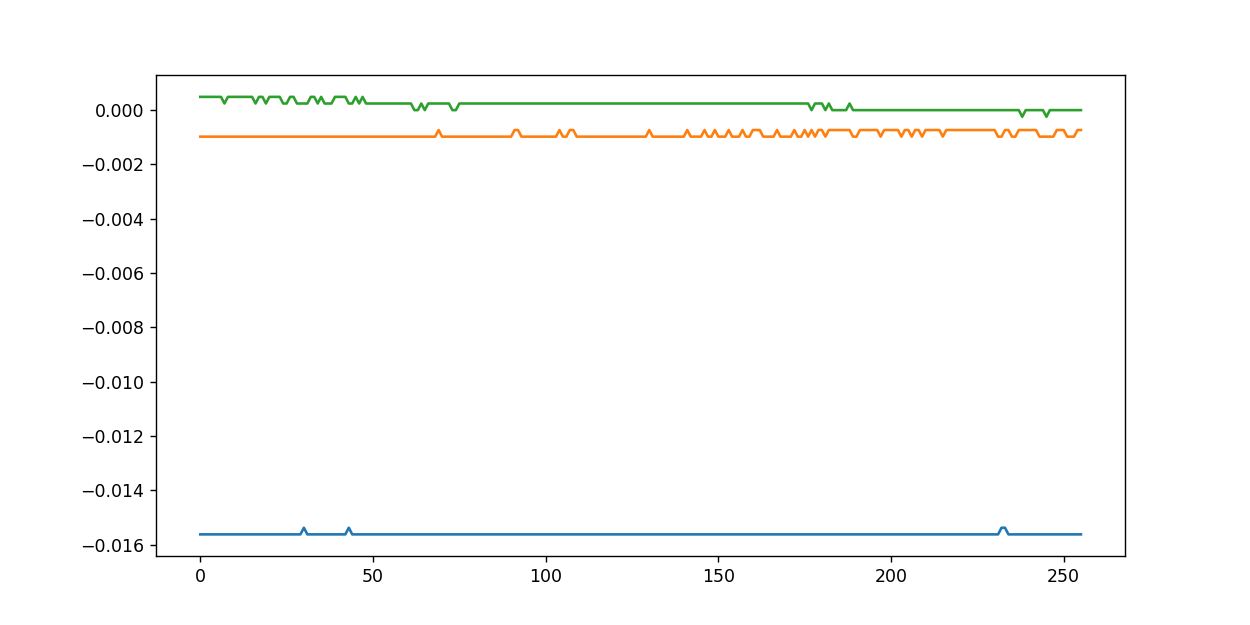

In [156]:
plt.figure(figsize=(10,5))
plt.plot(X_acc_test[20])
# plt.plot(X_ppg_pred[330],'r')
plt.show()

In [8]:
y_rr_pred = sequence_autoencoder.predict(X_ppg_test)

<IPython.core.display.Javascript object>


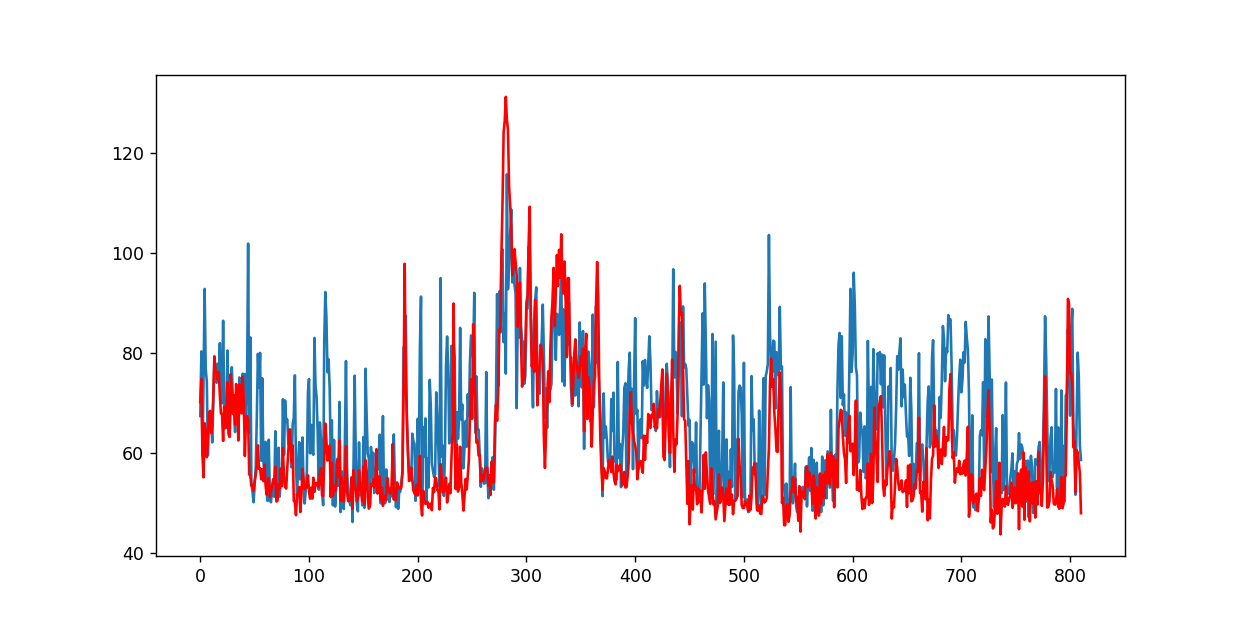

In [9]:
plt.figure(figsize=(10,5))
plt.plot(y_rr_pred)
plt.plot(y_rr_test,'r')

In [10]:
differences = np.abs(y_rr_pred-y_rr_test)

In [11]:
relative_powers = [np.mean(a[:,-1]) for a in X_qual_test]

<IPython.core.display.Javascript object>


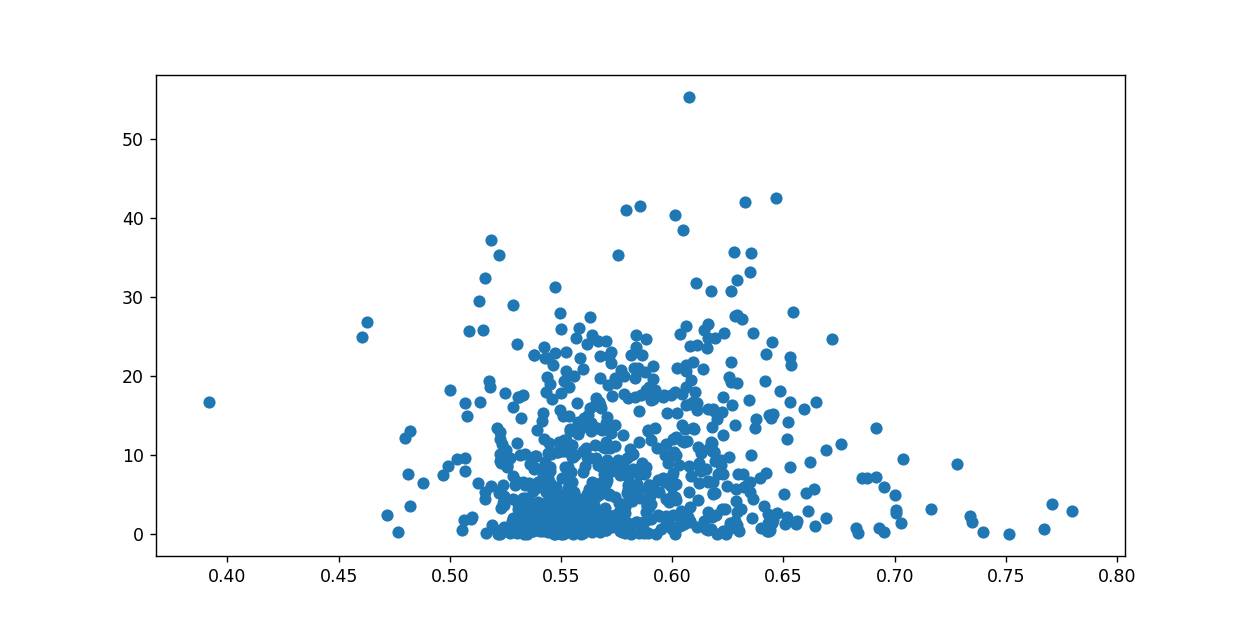

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(relative_powers,differences)
plt.show()

In [14]:
np.mean(differences)

8.563876893290832